In [ ]:
### script to calculate features. The features that include DBH are here made with the DBH from the QSM files. 
# Using a DBH based on the point point cloud (e.g. the DBH algorithm presented), is advised!

In [2]:
import pandas as pd
import math
import os
import numpy as np
from argparse import Namespace
import pathlib
import matplotlib as plt
import matplotlib.pyplot as mplt
#from shapely import geometry
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio
import matplotlib.cm as cmx
import itertools
%matplotlib notebook

In [3]:
dataDir= ""
qsm=[]
for file in os.listdir(dataDir): #or dataDir
    qsm.append(sio.loadmat(dataDir + file))

### make dataframes

In [37]:
Bord=[]
X=[]
Y=[]
Z=[]
cCHI=[]
cPAR=[]
cExt=[]
TreeData=[]
ax1=[]
ax2=[]
ax3=[]
CLen=[]
rad=[]
BAng=[]
BOB=[]
FCB=[]
BLen=[]
BChi=[]
CiB=[]
BoC=[]
for tree in qsm:
    Bord.append(tree['BoC'][:,1])
    X.append(tree['Sta'][:,0])
    Y.append(tree['Sta'][:,1])
    Z.append(tree['Sta'][:,2])
    cCHI.append(tree['CChi'])
    cPAR.append(tree['CPar'])
    cExt.append(tree['CExt'])
    TreeData.append(tree['TreeData'])
    ax1.append(tree['Axe'][:,0])
    ax2.append(tree['Axe'][:,1])
    ax3.append(tree['Axe'][:,2])
    CLen.append(tree['Len'][:,0])
    rad.append(tree['Rad'][:,0])
    BAng.append(tree['BAng'][:,0])
    BOB.append(tree['BOrd'][:,0])
    FCB.append(tree['FCB'][:,0])
    BLen.append(tree['BLen'][:,0])
    BChi.append(tree['BChi'])
    CiB.append(tree['CiB'])
    BoC.append(tree['BoC'])
data=pd.DataFrame({'BoC':BoC, 'CiB':CiB, 'BChi':BChi, 'BLen':BLen,'FCB':FCB,'branch_order_b':BOB,'BAng':BAng, 
                    'branch_order':Bord,'cyl_rad':rad,'X':X,'Y':Y,'Z':Z,'cCHI':cCHI,'cEXT':cExt, 'cPAR':cPAR,
                    'TreeData':TreeData,'ax1':ax1,'ax2':ax2,'ax3':ax3,'cyl_length':CLen})

### Crown determination

In [6]:
def labelling(row):
    tree = pd.DataFrame({'branch_order':row.branch_order,'X':row.X,'Y':row.Y, 'Z':row.Z,'parents':row.cPAR[:,0], 'children':row.cCHI[:,0], 'extension':row.cEXT[:,0], 'crown':[0]*len(row.cEXT),'Height':row.TreeData[3]}, index=range(1, len(row.branch_order)+1))
    order_zero=tree.loc[row.branch_order==0,:]
    if max(tree.loc[:,'branch_order']) >= 3:
        order_threshold=3
    else:
        order_threshold=max(tree.loc[:,'branch_order'])

    x=tree.loc[:,'branch_order']>=order_threshold
    ind=list(itertools.compress(range(len(x)), x))
    ind2=[1+x for x in ind]
    tree.loc[ind2,'crown']=1 #matlabindexen

    #parents adden
    #tree
    CR=ind2
    CR_old=[]
    while CR !=CR_old:
        CR_old=CR
        tree.loc[tree.loc[CR,'parents'],'crown']=1
        tree.loc[range(1,len(order_zero)+1),'crown']=0
        cr=tree.loc[:,'crown']==1
        CR=[1+cr for cr in list(itertools.compress(range(len(cr)), cr))]
        #delete CRs in list part from trunk
        for t in range(1,len(order_zero)+1):
            if t in CR:
                CR.remove(t)
            else:
                pass
    #lowest point with parent 0, 
    t1=tree.loc[tree.loc[:,'crown']==1,:]
    t2=t1.loc[t1.loc[:,'branch_order']==1,:]
    r=[]
    for t in t2.loc[:,'parents']:
        if tree.loc[t,'branch_order']==0:
            r.append(t2.loc[t2.loc[:,'parents']==t,'Z'].tolist()[0])
    height=min(r) 

    x=tree.loc[:,'Z']>=height
    ind=list(itertools.compress(range(len(x)), x))
    ind2=[1+x for x in ind]
    tree.loc[ind2,'crown']=1
    tree.loc[range(1,len(order_zero)+1),'crown']=0

    #append children
    trial=[]
    while tree.loc[:,'crown'].tolist() != trial:
        trial=tree.loc[:,'crown'].tolist()
        childs=tree.loc[tree.loc[:,'crown']==1,'children'].tolist()
        for i in childs:
            if i.size>0:
                for j in i:
                    tree.loc[j,'crown']==1
    # tree = create_tree()
    return tree

In [16]:
DATA=[]
k=0
for i in range(len(data)):
    k=k+1
    DATA.append(labelling(data.loc[i]))

### Crown Evenness

In [9]:
def crownEven(crown):
    import math
    CrEv=crown
    R=[]
    theta=[]
     #xyz coordinaten 
    MPX=[]
    MPY=[]
    B1theta=[]
    B2theta=[]
    B3theta=[]
    B4theta=[]
    B5theta=[]
    B6theta=[]
    B7theta=[]
    B8theta=[]
    B1rad=[]
    B2rad=[]
    B3rad=[]
    B4rad=[]
    B5rad=[]
    B6rad=[]
    B7rad=[]
    B8rad=[]
    B1height=[]
    B2height=[]
    B3height=[]
    B4height=[]
    B5height=[]
    B6height=[]
    B7height=[]
    B8height=[]
    bins=[1*2*math.pi/8-math.pi,2*2*math.pi/8-math.pi,3*2*math.pi/8-math.pi,4*2*math.pi/8-math.pi,5*2*math.pi/8-math.pi,6*2*math.pi/8-math.pi,7*2*math.pi/8-math.pi,2*math.pi/1-math.pi]

    #middelpunt boom?
    t1=CrEv.loc[CrEv.loc[:,'crown']==1,:]
    t2=t1.loc[t1.loc[:,'branch_order']==1,:]
    r=[]
    for t in t2.loc[:,'parents']:
        if CrEv.loc[t,'branch_order']==0:
            r.append(t2.loc[t2.loc[:,'parents']==t,'Z'].tolist()[0])
    height=min(r)
    MPX=t2.loc[t2.loc[:,'Z']==height,'X'].tolist()[0]
    MPY=t2.loc[t2.loc[:,'Z']==height,'Y'].tolist()[0]

    t1.loc
    for x,y in zip(t1.loc[:,'X'],t1.loc[:,'Y']):
        R.append(math.sqrt((x-MPX)**2+(y-MPY)**2)) #polaire coordinaten tov middelpunt boom
        theta.append(np.arctan2(y-MPY, x-MPX))

    #theta.append(math.atan((y[i]-MPY)/(x[i]-MPX)))
    x=t1.loc[:,'X'].tolist()
    y=t1.loc[:,'Y'].tolist()
    z=t1.loc[:,'Z'].tolist()
    for j in range(len(theta)):
        if theta[j]<bins[0]:
            B1theta.append(x[j])
            B1rad.append(y[j])
            B1height.append(z[j])
        elif theta[j]<bins[1]:
            B2theta.append(x[j])
            B2rad.append(y[j])
            B2height.append(z[j])
        elif theta[j]<bins[2]:
            B3theta.append(x[j])
            B3rad.append(y[j])
            B3height.append(z[j])
        elif theta[j]<bins[3]:
            B4theta.append(x[j])
            B4rad.append(y[j])
            B4height.append(z[j])
        elif theta[j]<bins[4]:
            B5theta.append(x[j])
            B5rad.append(y[j])
            B5height.append(z[j])
        elif theta[j]<bins[5]:
            B6theta.append(x[j])
            B6rad.append(y[j])
            B6height.append(z[j])
        elif theta[j]<bins[6]:
            B7theta.append(x[j])
            B7rad.append(y[j])
            B7height.append(z[j])
        elif theta[j]<bins[7]:
            B8theta.append(x[j])
            B8rad.append(y[j])
            B8height.append(z[j])
    if not B1height or not B2height or not B3height or not B4height or not B5height or not B6height or not B7height or not B8height:
        CrownEveness=0
    else:
        Hmin=min([min(B1height),min(B2height),min(B3height),min(B4height),min(B5height),min(B6height),min(B7height),min(B8height)])
        Hmax=max([min(B1height),min(B2height),min(B3height),min(B4height),min(B5height),min(B6height),min(B7height),min(B8height)])            
        CrownEveness=(Hmin-min(CrEv.loc[:,'Z'].tolist()))/(Hmax-min(CrEv.loc[:,'Z'].tolist()))#(Hmax-Hmin)/(t1.loc[:,'Height'].tolist()[1])
    return CrownEveness


<IPython.core.display.Javascript object>


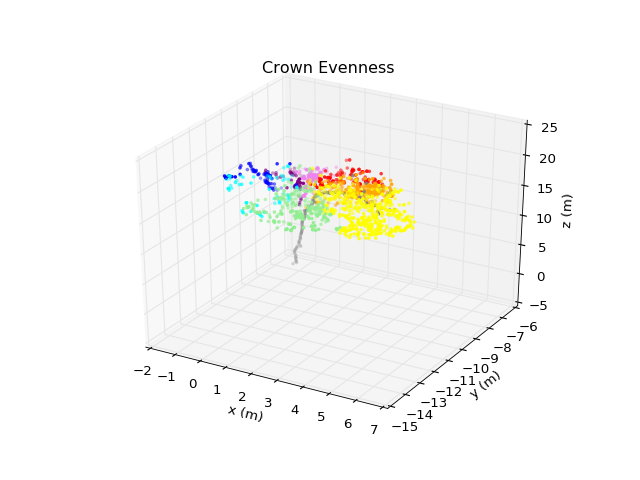

In [137]:
#visualisation crown eveness
fig= mplt.figure()
ax= mplt.axes(projection='3d')
#ax.scatter(Locations[0],Locations[1],Locations[2],s=20,c='green',linewidths=0)
Locationx=CrEv.loc[CrEv.loc[:,'crown']==0,'X']
Locationy=CrEv.loc[CrEv.loc[:,'crown']==0,'Y']
Locationz=CrEv.loc[CrEv.loc[:,'crown']==0,'Z']
ax.scatter(Locationx,Locationy,Locationz,s=10,c='grey',linewidths=0)

ax.scatter(B1theta,B1rad,B1height,s=10,c='blue',linewidths=0)
ax.scatter(B2theta,B2rad,B2height,s=10,c='cyan',linewidths=0)
ax.scatter(B3theta,B3rad,B3height,s=10,c='lightgreen',linewidths=0)
ax.scatter(B4theta,B4rad,B4height,s=10,c='yellow',linewidths=0)
ax.scatter(B5theta,B5rad,B5height,s=10,c='orange',linewidths=0)
ax.scatter(B6theta,B6rad,B6height,s=10,c='red',linewidths=0)
ax.scatter(B7theta,B7rad,B7height,s=10,c='violet',linewidths=0)
ax.scatter(B8theta,B8rad,B8height,s=10,c='purple',linewidths=0)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
mplt.title("Crown Evenness")
mplt.show()
mplt.savefig('CrownEvenness.png')


In [60]:
CrEV=[]
k=0
for i in range(len(DATA)):
    k=k+1
    CrEV.append(crownEven(DATA[i]))

### Tree Radius/Crown Diameter

In [11]:
def TreeRadius(row):
    #divide tree in three vertical bins
    #centre point: average of mean points of stem cylinders in bin
    #if bin doesnt contain stem cylinders: use centre of previous bin

    #tree radius: radius of a cilinder whose axis is vertical and goes through centre point, contains 90% of the volume of the cylinders in that bin

    #crown diameter: two times the maximum vertical bin radius
    #dataB=pd.DataFrame({'branch_order':Bord,'X':X,'Y':Y,'Z':Z,'cCHI':cCHI,'cEXT':cExt, 'cPAR':cPAR,'TreeData':TreeData,'ax1':ax1,'ax2':ax2,'ax3':ax3,'cyl_length':CLen})
    tree = pd.DataFrame({'branch_order':row.branch_order,'ax1':row.ax1,'ax2':row.ax2,'ax3':row.ax3,'startX':row.X,'startY':row.Y, 'startZ':row.Z,'cX':[0]*len(row.X),'cY':[0]*len(row.X),'cZ':[0]*len(row.X),'Bin':[0]*len(row.X),'rad_from_center':[0]*len(row.X),'cyl_vol':[0]*len(row.X),'cyl_length':row.cyl_length, 'cyl_rad':row.cyl_rad,'Height':row.TreeData[3]},index=range(1, len(row.Z)+1))

    #mean points of cilinders?
    tree.loc[:,'cX']=tree.loc[:,'cyl_length']*tree.loc[:,'ax1']/2+tree.loc[:,'startX'] 
    tree.loc[:,'cY']=tree.loc[:,'cyl_length']*tree.loc[:,'ax2']/2+tree.loc[:,'startY'] 
    tree.loc[:,'cZ']=tree.loc[:,'cyl_length']*tree.loc[:,'ax3']/2+tree.loc[:,'startZ'] 

    #cylinder volume
    tree.loc[:,'cyl_vol']=tree.loc[:,'cyl_length']*(tree.loc[:,'cyl_rad']**2)*math.pi
    #3 vertical bins
    height=max(tree.loc[:,'cZ'])- min(tree.loc[:,'cZ']) 
    bins=[min(tree.loc[:,'cZ'])+height/3,min(tree.loc[:,'cZ'])+height*2/3,max(tree.loc[:,'cZ'])]
    for z in range(1,len(tree.loc[:,'cZ'])+1):
        if tree.loc[z,'cZ']<=bins[0]:
            tree.loc[z,'Bin']=1
        elif tree.loc[z,'cZ']<=bins[1]:
            tree.loc[z,'Bin']=2
        else:
            tree.loc[z,'Bin']=3
    stem=tree.loc[tree.loc[:,'branch_order']==0,:]
    bin1=tree.loc[tree.loc[:,'Bin']==1,:]
    bin2=tree.loc[tree.loc[:,'Bin']==2,:]
    bin3=tree.loc[tree.loc[:,'Bin']==3,:]
    if not stem.loc[tree.loc[:,'Bin']==3,'cZ'].tolist() or not stem.loc[tree.loc[:,'Bin']==2,'cZ'].tolist():
        if not stem.loc[tree.loc[:,'Bin']==2,'cZ'].tolist():
            MPXbin1=np.mean(stem.loc[stem.loc[:,'Bin']==1,'cX'].tolist())
            MPYbin1=np.mean(stem.loc[stem.loc[:,'Bin']==1,'cY'].tolist())
            MPZbin1=np.mean(stem.loc[stem.loc[:,'Bin']==1,'cZ'].tolist())
            MPXbin2=MPXbin1
            MPYbin2=MPYbin1
            MPZbin2=MPZbin1
            MPXbin3=MPXbin1
            MPYbin3=MPYbin1
            MPZbin3=MPZbin1
        else:
            MPXbin1=np.mean(stem.loc[stem.loc[:,'Bin']==1,'cX'].tolist())
            MPYbin1=np.mean(stem.loc[stem.loc[:,'Bin']==1,'cY'].tolist())
            MPZbin1=np.mean(stem.loc[stem.loc[:,'Bin']==1,'cZ'].tolist())
            MPXbin2=np.mean(stem.loc[stem.loc[:,'Bin']==2,'cX'].tolist())
            MPYbin2=np.mean(stem.loc[stem.loc[:,'Bin']==2,'cY'].tolist())
            MPZbin2=np.mean(stem.loc[stem.loc[:,'Bin']==2,'cZ'].tolist())
            MPXbin3=MPXbin1
            MPYbin3=MPYbin1
            MPZbin3=MPZbin1
    else:
        MPXbin1=np.mean(stem.loc[stem.loc[:,'Bin']==1,'cX'].tolist())
        MPYbin1=np.mean(stem.loc[stem.loc[:,'Bin']==1,'cY'].tolist())
        MPZbin1=np.mean(stem.loc[stem.loc[:,'Bin']==1,'cZ'].tolist())
        MPXbin2=np.mean(stem.loc[stem.loc[:,'Bin']==2,'cX'].tolist())
        MPYbin2=np.mean(stem.loc[stem.loc[:,'Bin']==2,'cY'].tolist())
        MPZbin2=np.mean(stem.loc[stem.loc[:,'Bin']==2,'cZ'].tolist())
        MPXbin3=np.mean(stem.loc[stem.loc[:,'Bin']==3,'cX'].tolist())
        MPYbin3=np.mean(stem.loc[stem.loc[:,'Bin']==3,'cY'].tolist())
        MPZbin3=np.mean(stem.loc[stem.loc[:,'Bin']==3,'cZ'].tolist())
    #radius bin?
    bin1=tree.loc[tree.loc[:,'Bin']==1,:]
    bin2=tree.loc[tree.loc[:,'Bin']==2,:]
    bin3=tree.loc[tree.loc[:,'Bin']==3,:]

    tree.loc[tree.loc[:,'Bin']==1,'rad_from_center']=[math.sqrt((m-MPXbin1)**2+(n-MPYbin1)**2) for m,n in zip(bin1.loc[:,'cX'],bin1.loc[:,'cY'])]
    tree.loc[tree.loc[:,'Bin']==2,'rad_from_center']=[math.sqrt((m-MPXbin2)**2+(n-MPYbin2)**2) for m,n in zip(bin2.loc[:,'cX'],bin2.loc[:,'cY'])]
    tree.loc[tree.loc[:,'Bin']==3,'rad_from_center']=[math.sqrt((m-MPXbin3)**2+(n-MPYbin3)**2) for m,n in zip(bin3.loc[:,'cX'],bin3.loc[:,'cY'])]

    bin1=tree.loc[tree.loc[:,'Bin']==1,:]
    bin2=tree.loc[tree.loc[:,'Bin']==2,:]
    bin3=tree.loc[tree.loc[:,'Bin']==3,:]

    max(bin3.loc[:,'rad_from_center'].tolist())
    bin1sort=bin1.sort_values(by=['rad_from_center'],ascending=True)
    bin2sort=bin2.sort_values(by=['rad_from_center'],ascending=True)
    bin3sort=bin3.sort_values(by=['rad_from_center'],ascending=True)
    Vol1=sum(bin1.loc[:,'cyl_vol'])
    Vol2=sum(bin2.loc[:,'cyl_vol'])
    Vol3=sum(bin3.loc[:,'cyl_vol'])
    i=len(bin1sort)-1
    volume=Vol1
    TreeRad=[]
    while volume> Vol1*0.9:
        volume=volume- bin1sort.iloc[i,:]['cyl_vol']
        i=i-1
    if i+1==len(bin1sort)-1:
        i=i-1
    else:
        i=i
    TreeRad.append(bin1sort.iloc[i+2]['rad_from_center'])  

    i=len(bin2sort)-1
    volume=Vol2
    while volume > Vol2*0.9:
        volume=volume- bin2sort.iloc[i,:]['cyl_vol']
        i=i-1
    if i+1==len(bin2sort)-1:
        i=i-1
    else:
        i=i
    TreeRad.append(bin2sort.iloc[i+2]['rad_from_center'])

    i=len(bin3sort)-1
    volume=Vol3
    while volume> Vol3*0.9:
        volume=volume- bin3sort.iloc[i,:]['cyl_vol']
        i=i-1
    if i+1==len(bin3sort)-1:
        i=i-1
    else:
        i=i
    TreeRad.append(bin3sort.iloc[i+2]['rad_from_center'])
    CrownDia=max(TreeRad)*2
    return TreeRad

In [134]:
TreeRad=data.apply(TreeRadius,axis=1)

<IPython.core.display.Javascript object>


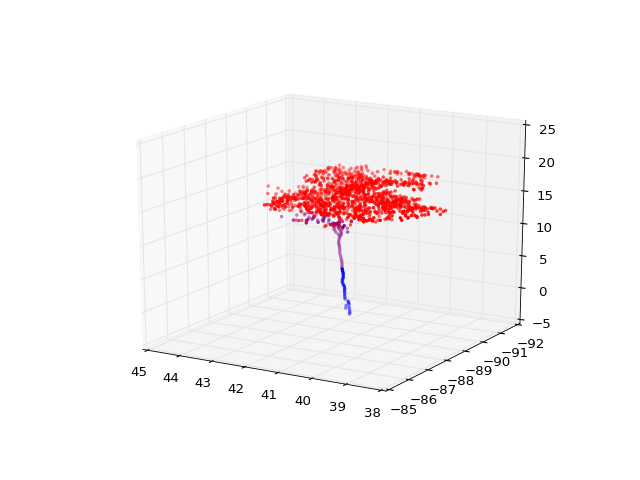

In [80]:
#Visualisation bins
fig= mplt.figure()
ax= mplt.axes(projection='3d')
#ax.scatter(Locations[0],Locations[1],Locations[2],s=20,c='green',linewidths=0)
Locationx1=tree.loc[tree.loc[:,'Bin']==1,'cX']
Locationy1=tree.loc[tree.loc[:,'Bin']==1,'cY']
Locationz1=tree.loc[tree.loc[:,'Bin']==1,'cZ']
Locationx2=tree.loc[tree.loc[:,'Bin']==2,'cX']
Locationy2=tree.loc[tree.loc[:,'Bin']==2,'cY']
Locationz2=tree.loc[tree.loc[:,'Bin']==2,'cZ']
Locationx3=tree.loc[tree.loc[:,'Bin']==3,'cX']
Locationy3=tree.loc[tree.loc[:,'Bin']==3,'cY']
Locationz3=tree.loc[tree.loc[:,'Bin']==3,'cZ']
ax.scatter(Locationx1,Locationy1,Locationz1,s=10,c='blue',linewidths=0)
ax.scatter(Locationx2,Locationy2,Locationz2,s=10,c='purple',linewidths=0)
ax.scatter(Locationx3,Locationy3,Locationz3,s=10,c='red',linewidths=0)

mplt.show()
mplt.savefig('CrownEvenness.png')

### Stem Branch Angle

In [13]:
def BranchAngle(row):
    tree=pd.DataFrame({'branch_order_b':row.branch_order_b,'BAng':row.BAng})
    BANG = np.median(tree.loc[tree.loc[:,'branch_order_b']==1,'BAng'])
    return BANG

In [24]:
stem_branch_angle=data.apply(BranchAngle,axis=1)

### Stem Branch Cluster Size

In [16]:
def stBrClSize(row):
    FCB=np.where([row['BoC'][i][2]==1 for i in range(len(row['BoC']))])[0] #python
    First_branch=np.where(row.branch_order==1)[0]-1 #to python
    first_cyls=list(set(FCB).intersection(First_branch))
    #StemCyl=row.branch_order
    cylhoogtes=sorted(row.Z[first_cyls])
    label=np.zeros(len(row.Z))
    cluster=[]
    for q in range(len(cylhoogtes)): #voor elke cylinder
        starth=cylhoogtes[q]-0.20 #interval start
        eindh=cylhoogtes[q]+0.20 #interval einde
        indh = [i for i, x in enumerate(cylhoogtes) if x >starth and x<eindh ]
        aantalcluster=0
        for r in range(len(indh)):
            if label[indh[r]]==1:
                pass
            else:
                if label[indh[r]]==0:
                    label[indh[r]]=1
                    aantalcluster=aantalcluster+1
                else:
                    pass

        if aantalcluster:
            cluster.append(aantalcluster)
    sbcs=np.mean(cluster)
    return sbcs


In [28]:
st_br_cl_size=data.apply(stBrClSize,axis=1)

### Stem Branch Radius

In [18]:
def StemBranchRadius(row): ##aanpassen met eigen FCB
    branches= pd.DataFrame({'FCB':row.FCB, 'branch_order_b':row.branch_order_b},index=range(1, len(row.branch_order_b)+1))
    cylinders= pd.DataFrame({'cPAR':row.cPAR[:,0],'cyl_rad':row.cyl_rad},index=range(1,len(row.cPAR)+1))
    fcb = np.where([row['BoC'][i][2]==1 for i in range(len(row['BoC']))]) #python indices
    FCB=[k+1 for k in fcb] #to matlab indices
    FCB=FCB[0][range(1,len(FCB[0]))]
    largest_branches=cylinders.loc[FCB,:].sort_values(by=['cyl_rad'],ascending=False)[0:10]
    radius_stem=cylinders.loc[largest_branches.loc[:,'cPAR'],'cyl_rad']
    StemBranchRadius=np.mean([x/y for (x,y) in zip(largest_branches.loc[:,'cyl_rad'].tolist(),radius_stem.tolist())])
    return StemBranchRadius

In [31]:
stem_branch_radius=data.apply(StemBranchRadius,axis=1)

### Stem Branch Length

In [20]:
def StemBranchLength(row):
    data=pd.DataFrame({'branch_order_b':row.branch_order_b, 'BLen':row.BLen})
    if not row.TreeData[9][0]:
        dbh=row.TreeData[10][0]/100 #to m
    else:
        dbh=row.TreeData[9][0]/100 #to m
    first_order=data.loc[data.loc[:,'branch_order_b']==1,'BLen']
    L= np.mean([x/dbh for x in first_order])
    return L

In [33]:
stem_branch_length_brazil=dataB.apply(StemBranchLength, axis=1)
stem_branch_length_gabon=dataG.apply(StemBranchLength, axis=1)
stem_branch_length_FG=dataFG.apply(StemBranchLength, axis=1)

In [21]:
stem_branch_length_Gh=dataGh.apply(StemBranchLength, axis=1)

### Stem Branch Distance

In [22]:
def StemBranchDistance(row):
### Average distance between 1st order branches computed using a moving average with a window with 1m. if empty: half
    FCB=np.where([row['BoC'][i][2]==1 for i in range(len(row['BoC']))])[0] #python
    First_branch=np.where(row.branch_order==1)[0]-1 #to python
    first_cyls=list(set(FCB).intersection(First_branch))
    #StemCyl=row.branch_order
    cylhoogtes=sorted(row.Z[first_cyls])
    if cylhoogtes:
        cylhoogtes1=cylhoogtes
        cylhoogtes2=cylhoogtes1[1:len(cylhoogtes1)]
        cylhoogtes1.pop()
        verschil=[x2 - x1 for (x1, x2) in zip(cylhoogtes1, cylhoogtes2)]
        avdist=[]
        for q in range(len(cylhoogtes)): #voor elke cylinder
            starth=cylhoogtes[q]-0.50 #interval start
            eindh=cylhoogtes[q]+0.50 #interval einde
            indh = [i for i, x in enumerate(cylhoogtes) if x >starth and x<eindh ]
            if len(indh)==1:
                avdist.append(0.5)
            else:
                dist=[]
                for r in range(len(indh)-1):
                    dist.append(verschil[indh[r]])

                avdist.append(np.mean(dist))

        sbd=np.mean(avdist)
    else:
        pass
    return sbd

In [35]:
stem_branch_distance=data.apply(StemBranchDistance, axis=1)


 ### Crown Start Height

In [24]:
for tree in DATA:
    CYL = tree['cyl_b_o']==1 
    IDX = tree['cyl_idx']==1
    #CR = tree['crown'] == 1
    CR = crown.loc[crown.loc[:,'crown']==1,:]
    p = np.logical_and(CYL, IDX)
    c = np.logical_and(p, CR)
    min_height = min(tree['Z'][c])
    CSH.append((min_height - min(tree['Z']))/tree.Height[1])

### Crown Height

In [26]:
def CrownHeight(crown):
    crowns=crown.loc[crown.loc[:,'crown']==1,:]
    height=(np.max(crowns.loc[:,'Z'])-np.min(crowns.loc[:,'Z']))/crown['Height'][1]
    return height

In [41]:
crown_height=[]
for i in range(len(DATA)):
    crown_height.append(CrownHeight(DATA[i]))

### Crown Diameter/height

In [28]:
height=[data.loc[i,'TreeData'][3][0] for i in range(len(data))]

NameError: name 'dataB' is not defined

In [30]:
def CrownDiamHeight(TreeRad, crownlist):
    height=[]
    for i in range(len(crownlist)):
        crown=crownlist[i]    
        crowns=crown.loc[crown.loc[:,'crown']==1,:]
        height.append(np.max(crowns.loc[:,'Z'])-np.min(crowns.loc[:,'Z']))
    
    diam=[max(TreeRad[i])*2 for i in range(len(TreeRad))]
    answer=[diam[i]/height[i] for i in range(len(height))]
    return answer

In [140]:
crown_diam_height=CrownDiamHeight(TreeRad,DATA)

### DBH/height ratio

In [32]:
def DBHHeight(row):
    if not row.TreeData[9][0]:
        dbh=row.TreeData[10][0]/100 #to m
    else:
        dbh=row.TreeData[9][0]/100 #to m
    height=row.TreeData[3][0]
    answer=dbh/height
    return answer

In [48]:
DBH_height=data.apply(DBHHeight,axis=1)



### DBH/treevolume

In [34]:
def DBHVol(row):
    if not row.TreeData[9][0]:
        dbh=row.TreeData[10][0]/100 #to m
    else:
        dbh=row.TreeData[9][0]/100 #to m
    vol=row.TreeData[0][0]/1000
    answer=dbh/vol
    return answer


In [50]:
DBH_vol_b=dataB.apply(DBHVol,axis=1)
DBH_vol_g=dataG.apply(DBHVol,axis=1)
DBH_vol_FG=dataFG.apply(DBHVol,axis=1)

In [35]:
DBH_vol_Gh=dataGh.apply(DBHVol,axis=1)

### Branch (2,3) radius/length

In [ ]:
def bra23(row):
    length=[]
    radius=[]
    for i in np.unique(row.BoC[:,0]):
        index = row.BoC[:,0]==i
        if row.branch_order[index][0]==2 or row.branch_order[index][0]==3: #all same branch order
            if sum(row.cyl_length[index])==0:
                pass
            else:
                length.append(sum(row.cyl_length[index]))
                radius.append(sum(row.cyl_rad[index]*row.cyl_length[index])/sum(row.cyl_length[index]))
        else:
            pass
    answer=np.mean([b/a for a,b in zip(length,radius)])
    return answer

In [ ]:
bra_23=data.apply(bra23,axis=1)

### Branch length/radius

In [ ]:
def bra(row):
    length=[]
    radius=[]
    for i in np.unique(row.BoC[:,0]):
        if i==1: #no stem
            pass
        else:
            index = row.BoC[:,0]==i
            if sum(row.cyl_length[index])==0:
                pass
            else:
                length.append(sum(row.cyl_length[index]))
                radius.append(sum(row.cyl_rad[index]*row.cyl_length[index])/sum(row.cyl_length[index]))
    answer=np.mean([a/b for a,b in zip(length,radius)])
    return answer
    

In [ ]:
branch_length_radius=data.apply(bra,axis=1)

### Branchvolume below 55% of height

In [39]:
# relative cylinder volume below 55% of tree height
def vol55(row):
    data=pd.DataFrame({'Z':row.Z, 'cvol':[0]*len(row.X),'cyl_length':row.cyl_length,'cyl_rad':row.cyl_rad,'branch_order':row.branch_order})
    height=row.loc['TreeData'][3][0]
    data.loc[:,'cvol']=data.loc[:,'cyl_length']*data.loc[:,'cyl_rad']**2*math.pi
    nostem=data.loc[data.loc[:,'branch_order']!=0,:]
    ans=sum(nostem.loc[(nostem.loc[:,'Z']-min(data.loc[:,'Z']))/height <= 0.55,'cvol'])/sum(nostem.loc[:,'cvol'])
    return ans

In [40]:
def vol55_metcrownalg(row,crowndata):
    crowns=crowndata['crown']
    data=pd.DataFrame({'Z':row.Z, 'cvol':[0]*len(row.X),'cyl_length':row.cyl_length,'cyl_rad':row.cyl_rad,'branch_order':row.branch_order})
    data.loc[:,'cvol']=data.loc[:,'cyl_length']*data.loc[:,'cyl_rad']**2*math.pi
    x=crowns==1
    kroon=data.loc[x.tolist(),:]
    height=(np.max(kroon.loc[:,'Z'])-np.min(kroon.loc[:,'Z']))
    ans=sum(kroon.loc[(kroon.loc[:,'Z']-min(kroon.loc[:,'Z']))/height <= 0.55,'cvol'])/sum(kroon.loc[:,'cvol'])
    return ans

In [119]:
vol55_1=dataB.apply(vol55,axis=1)


In [125]:
vol55_2=[]
for i in range(len(dataB)):
    vol55_2.append(vol55_metcrownalg(data.loc[i],DATA[i]))

### Total volume under 70% height

In [ ]:
# relative cylinder volume below 55% of tree height
def vol70(row):
    data=pd.DataFrame({'Z':row.Z, 'cvol':[0]*len(row.X),'cyl_length':row.cyl_length,'cyl_rad':row.cyl_rad,'branch_order':row.branch_order})
    height=row.loc['TreeData'][3][0]
    data.loc[:,'cvol']=data.loc[:,'cyl_length']*data.loc[:,'cyl_rad']**2*math.pi
    ans=sum(data.loc[(data.loc[:,'Z']-min(data.loc[:,'Z']))/height <= 0.70,'cvol'])/sum(data.loc[:,'cvol'])
    return ans

In [ ]:
vol70=data.apply(vol70,axis=1)

### cylinder length/tree volume

In [43]:
### cyl length/tree volume
def CylLengthVol(row):
    ans=sum(row.cyl_length)/row.loc['TreeData'][0][0]*1000
    return ans

In [57]:
cyl_length_vol=dataB.apply(CylLengthVol,axis=1)


### cylinder length/tree v. branches

In [45]:
def CylLengthVolB(row):
    branch_length=[]
    branch_volume=[]
    data=pd.DataFrame({'branch_order':row.branch_order, 'cyl_length':row.cyl_length,
                       'cyl_rad':row.cyl_rad})
    nostem=data.loc[data.loc[:,'branch_order']!=0,:]
    for i in range(len(nostem.loc[:,'cyl_length'])):
        if nostem.iloc[i]['cyl_length']==0:
            pass
        else:
            branch_length.append(nostem.iloc[i]['cyl_length'])
            branch_volume.append(math.pi* nostem.iloc[i]['cyl_rad']**2 * nostem.iloc[i]['cyl_length'])
    answer=np.mean([i/j for i,j in zip(branch_length,branch_volume)])
    return answer

In [172]:
cyl_length_volB=data.apply(CylLengthVolB,axis=1)

### Relative stem volume

In [47]:

def volstemtotal(row):
    data=pd.DataFrame({'branch_order':row.branch_order, 'cvol':[0]*len(row.X),'cyl_length':row.cyl_length,'cyl_rad':row.cyl_rad})
    data.loc[:,'cvol']=data.loc[:,'cyl_length']*data.loc[:,'cyl_rad']**2*math.pi
    ans=sum(data.loc[data.loc[:,'branch_order']==0,'cvol'])/row.loc['TreeData'][0][0]*1000
    return ans

In [90]:
volstemtotal_b=dataB.apply(volstemtotal,axis=1)
volstemtotal_g=dataG.apply(volstemtotal,axis=1)
volstemtotal_fg=dataFG.apply(volstemtotal,axis=1)

In [48]:
volstemtotal_gh=dataGh.apply(volstemtotal,axis=1)

### Vol second branches/vol first branches

In [51]:
### van eerste tot en met derde orde branches: BANG
def vol21branches(row):
    data=pd.DataFrame({'branch_order':row.branch_order, 'cvol':[0]*len(row.X),'cyl_length':row.cyl_length,'cyl_rad':row.cyl_rad})
    data.loc[:,'cvol']=data.loc[:,'cyl_length']*data.loc[:,'cyl_rad']**2*math.pi
    vol_first_branches=sum(data.loc[data.loc[:,'branch_order']==1,'cvol'])
    vol_second_branches=sum(data.loc[data.loc[:,'branch_order']==2,'cvol'])
    ans=vol_second_branches/vol_first_branches
    return ans

In [73]:
VOL21branches=data.apply(vol21branches,axis=1) 

In [ ]:
### feature crown area/DBH and crown area/height are not listed in this file, because the crown area was not calculated
#with python.